In [1]:
import os
import json
import time
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import cartopy.feature as cf
import cartopy.crs as ccrs

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from playsound import playsound

import psutil
from joblib import Parallel, delayed

from scipy.optimize import differential_evolution

from pathos.multiprocessing import ProcessingPool as Pool

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, os.path.abspath("../function"))
from ART_downscale import myfun_sse, fit_yearly_weibull_update, gamma_manual
from ART_preprocessing import create_box, autocorrelation_neighborhood

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
# product, time_reso = 'IMERG', '1dy'

# product, time_reso = 'IMERG', '3h'
# product, time_reso = 'MSWEP', '3h'
product, time_reso = 'CMORPH', '3h'

yy_s, yy_e = 2002, 2012
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
json_read = f'../json/{product}_{time_reso}.json'
print(f'Read json: {json_read}')

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

Read json: ../json/CMORPH_3h.json


In [4]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [5]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(veneto_dir)
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [6]:
print(f'Reading data: {param['file']}') 
dir_data = os.path.join(dir_base,product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP':
    PRE_data = PRE_data.sel(lat=slice(lat_max+1.5, lat_min-1.5), lon=slice(lon_min-1.5, lon_max+1.5))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min-1.5, lat_max+1.5), lon=slice(lon_min-1.5, lon_max+1.5))

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data

Reading data: CMORPH_Italy_3hr_1998_01_01_2023_12_31.nc


<xarray.Dataset> Size: 62MB
Dimensions:  (time: 32144, lat: 20, lon: 24)
Coordinates:
  * lat      (lat) float32 80B 43.12 43.38 43.62 43.88 ... 47.38 47.62 47.88
  * lon      (lon) float32 96B 9.125 9.375 9.625 9.875 ... 14.38 14.62 14.88
  * time     (time) datetime64[ns] 257kB 2002-01-01 ... 2012-12-31T21:00:00
Data variables:
    PRE      (time, lat, lon) float32 62MB ...
Attributes:
    description:  CMORPH hourly data for Italy region in 1998 to 2023

In [7]:
# Extracting lat and lon points for Study area (VENETO)
if product == 'MSWEP':
    ds_veneto = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    ds_veneto = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

if time_reso == '3h':
    PRE_mean = ds_veneto.resample(time ='D').sum(dim='time', skipna=False).mean(dim='time', skipna=True)
elif time_reso == '1dy':
    PRE_mean = ds_veneto.mean(dim='time', skipna=True)
else:
    raise SystemExit(f"Time resolution not found: {time_reso}")

lat_ref = ds_veneto.lat.values
lon_ref = ds_veneto.lon.values

ndices_lat = np.where(np.isin(lats, lat_ref))[0]
ndices_lon = np.where(np.isin(lons, lon_ref))[0]

lon2d_ref, lat2d_ref = np.meshgrid(lon_ref, lat_ref)

del ds_veneto

PRE_mean

<xarray.Dataset> Size: 568B
Dimensions:  (lat: 10, lon: 12)
Coordinates:
  * lat      (lat) float32 40B 44.62 44.88 45.12 45.38 ... 46.38 46.62 46.88
  * lon      (lon) float32 48B 10.62 10.88 11.12 11.38 ... 12.88 13.12 13.38
Data variables:
    PRE      (lat, lon) float32 480B 1.853 1.702 1.577 ... 1.857 2.041 2.203

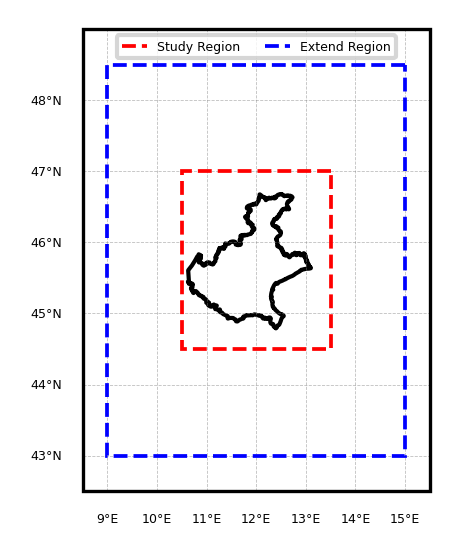

In [8]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(2,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min-2, lon_max+2, lat_min-2, lat_max+2],crs=proj)
VENETO.plot(facecolor='None', ax=ax1)

ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.9,edgecolor='r',facecolor='None',zorder=5))
ax1.add_patch(patches.Rectangle((lon_max+1.5,lat_max+1.5),(lon_min-1.5)-(lon_max+1.5),(lat_min-1.5)-(lat_max+1.5),linestyle='--',linewidth=0.9,edgecolor='b',facecolor='None',zorder=5))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.plot([],[],linestyle='--',linewidth=0.9,color='r', label='Study Region')
ax1.plot([],[],linestyle='--',linewidth=0.9,color='b', label='Extend Region')

ax1.legend(fontsize=3,ncols=2,loc='upper center')

In [9]:
def gamma_3h_1dy(DATA_in, time_reso, lat_c, lon_c, PARAM):
    if time_reso == '3h':
        PRE_daily = DATA_in.resample(time ='D').sum(dim='time', skipna=False)
        box_3h, _ = create_box(PRE_daily, lat_c, lon_c, PARAM['npix'], PARAM['radio'])
        tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48, 96])*PARAM['dt']
    elif time_reso == '1dy':
        tscales = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])*PARAM['dt']
        box_3h, _ = create_box(DATA_in, lat_c, lon_c, PARAM['npix'], PARAM['radio'])
        PRE_daily = DATA_in
    else:
        print(f'Erorr: {time_reso} not valid')
        return None

    i_ = np.where(lats==lat_c)[0][0]
    j_ = np.where(lons==lon_c)[0][0]

    IMERG_pixel_1dy = PRE_daily['PRE'][:,i_,j_].data
    IMERG_pixel_1dy_xr = xr.DataArray(
                IMERG_pixel_1dy, 
                coords={'time':PRE_daily['time'].values}, 
                dims=('time'))

    IMERG_WEIBULL_YEAR = fit_yearly_weibull_update(
                    IMERG_pixel_1dy_xr, 
                    thresh=PARAM['thresh'], 
                    maxmiss=PARAM['maxmiss'])

    vdist, vcorr, _ = autocorrelation_neighborhood(
                    box_3h, 
                    t_target = PARAM['target_t'], 
                    thresh = PARAM['thresh'], 
                    cor_method = PARAM['corr_method'])

    vdist_sorted = np.sort(vdist) # order distance
    vcorr_sorted = vcorr[np.argsort(vdist)] # order correlation in relation to distance
    toll_cluster = 0.5

    cluster = np.zeros(len(vdist_sorted))
    count = 0
    for i in range(1, len(vdist_sorted)):
        if np.abs(vdist_sorted[i]-vdist_sorted[i-1]) < toll_cluster:
            cluster[i] = count
        else:
            count = count + 1
            cluster[i] = count

    clust = set(cluster) # Extract only the uniques values
    nclust = len(clust) # Numero de grupos

    vdist_ave = np.zeros(nclust)
    vcorr_ave = np.zeros(nclust)
    for ei, elem in enumerate(clust):
        di = vdist_sorted[cluster==elem] # Distance
        ci = vcorr_sorted[cluster==elem] # Correlation
        vdist_ave[ei] = np.mean(di) # Mean Distance
        vcorr_ave[ei] = np.mean(ci) # Mean Correlation

    bounds = [(0.0, 25.0),(0, 0.3)] # NEW LIMITS USING ALL CORRELATIONS FUNCTION IN VENETO

    def myfun(pardown):
        return myfun_sse(vdist_ave, vcorr_ave, pardown, PARAM['L1'], acf=PARAM['acf'])

    # with Pool(nodes=PARAM['GAMMA_cores']) as pool:
    #         resmin = differential_evolution(
    #             myfun,
    #             bounds,
    #             disp=True,
    #             tol=0.03,
    #             atol=0.03,
    #             workers=pool.map,
    #             updating='deferred'
    #         )

    resmin = differential_evolution(
                myfun,
                bounds,
                disp=True,
                tol=0.03,
                atol=0.03,
                workers=1,
                updating='deferred'
            )

    param1 = resmin.x[0]
    param2 = resmin.x[1]

    gamma = gamma_manual(IMERG_WEIBULL_YEAR[:,0], 
                        IMERG_WEIBULL_YEAR[:,1], 
                        IMERG_WEIBULL_YEAR[:,2], 
                        PARAM['L1'], 
                        PARAM['L0'], 
                        (param1, param2), 
                        acf=PARAM['acf'])

    return gamma

In [10]:
len(ndices_lat)*len(ndices_lon)

120

In [11]:
# # 47 min
# count = 0
# for i in ndices_lat[0:5]:
#     for j in ndices_lon[0:5]:
#         print(f'{count} of {len(ndices_lat)*len(ndices_lon)}')
#         lat_c = lats[i]
#         lon_c = lons[j]
#         gamma = gamma_3h_1dy(PRE_data, time_reso, lat_c, lon_c, param)
#         count += 1

In [12]:
# 16 min
def compute_for_point(lat_idx, lon_idx):
    return gamma_3h_1dy(PRE_data, time_reso, lats[lat_idx], lons[lon_idx], param)

Resource = []

start_time = time.time()

results = Parallel(n_jobs=param['GAMMA_cores'])(
    delayed(compute_for_point)(la, lo) for la in ndices_lat[0:5] for lo in ndices_lon[0:5]
    )

end_time = time.time()

elapsed_time = end_time - start_time
elapsed_minutes = elapsed_time / 60
memory_consumed = psutil.virtual_memory().used / 1024 ** 3

print(f"Elapsed time: {elapsed_minutes:.2f} minutes")
print(f"Memory consumed: {memory_consumed:.3f} GB")

differential_evolution step 1: f(x)= 0.0012851789487242536
differential_evolution step 1: f(x)= 0.007207254690139044
differential_evolution step 1: f(x)= 0.010665823391653416
differential_evolution step 1: f(x)= 0.007421248765039462
differential_evolution step 1: f(x)= 0.007504682667695613
differential_evolution step 1: f(x)= 0.016175376929257055
differential_evolution step 1: f(x)= 0.012338337519243799
differential_evolution step 1: f(x)= 0.04694075155800293
differential_evolution step 1: f(x)= 0.003960776956590145
differential_evolution step 1: f(x)= 0.052665725461518
differential_evolution step 1: f(x)= 0.004900631407194075
differential_evolution step 1: f(x)= 0.006074680309411494
differential_evolution step 1: f(x)= 0.003779986671958702
differential_evolution step 2: f(x)= 0.0012851789487242536
Polishing solution with 'L-BFGS-B'
differential_evolution step 1: f(x)= 0.05465859395463196
differential_evolution step 2: f(x)= 0.006074987193769027
differential_evolution step 1: f(x)= 0.0

In [14]:
playsound("../sound/HOMER_DOH.mp3")